<a href="https://colab.research.google.com/github/Armanskij/Projeto-Pipeline_AWS_Telegram/blob/main/Config_bot_telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram I
Caderno de **Aula**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Contexto;</li>
  <li>Telegram;</li>
  <li>Dados.</li>
</ol>

---

# **Aulas**

## 1\. Contexto

### **1.1. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

### **1.2. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

### **1.3. Arquitetura**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

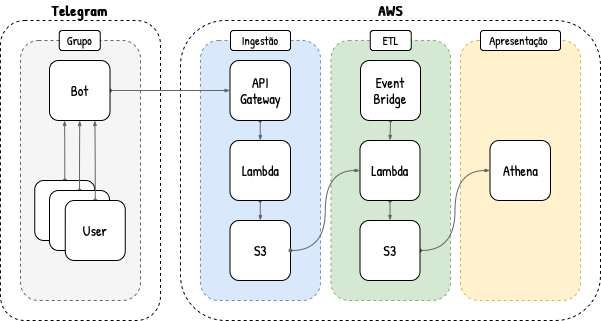

 - **Telegram**

O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

 - **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.

 - **AWS | ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

 - **AWS | Apresentação**

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.

## 2\. Telegram

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, vamos criar um grupo, criar um **bot** e adiciona-lo ao grupo recém criado. O *bot* então captará **todas** as mensagens enviadas no grupo. As mensagens pode ser acessadas através da API (*application programming interface*) de *bots* dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api)).

### **2.1. Conta**

Para criar uma conta no **Telegram**, basta fazer o download do aplicativo na loja de aplicativos do seu *smartphone*. Uma vez criada, acesse sua conta através da versão *web* da plataforma de mensagens neste [link](https://web.telegram.org).

### **2.2. Bot**

Para criar um *bot*:

1. Abra o *chat* com o `BotFather`;
1. Digite `/newbot`;
1. Digite o nome do *bot*;
1. Digite o nome de usuário do *bot* (precisa terminar com sufixo `_bot`);
1. Salve o `token` de acesso a API HTTP em um <font color='red'>local seguro</font>.

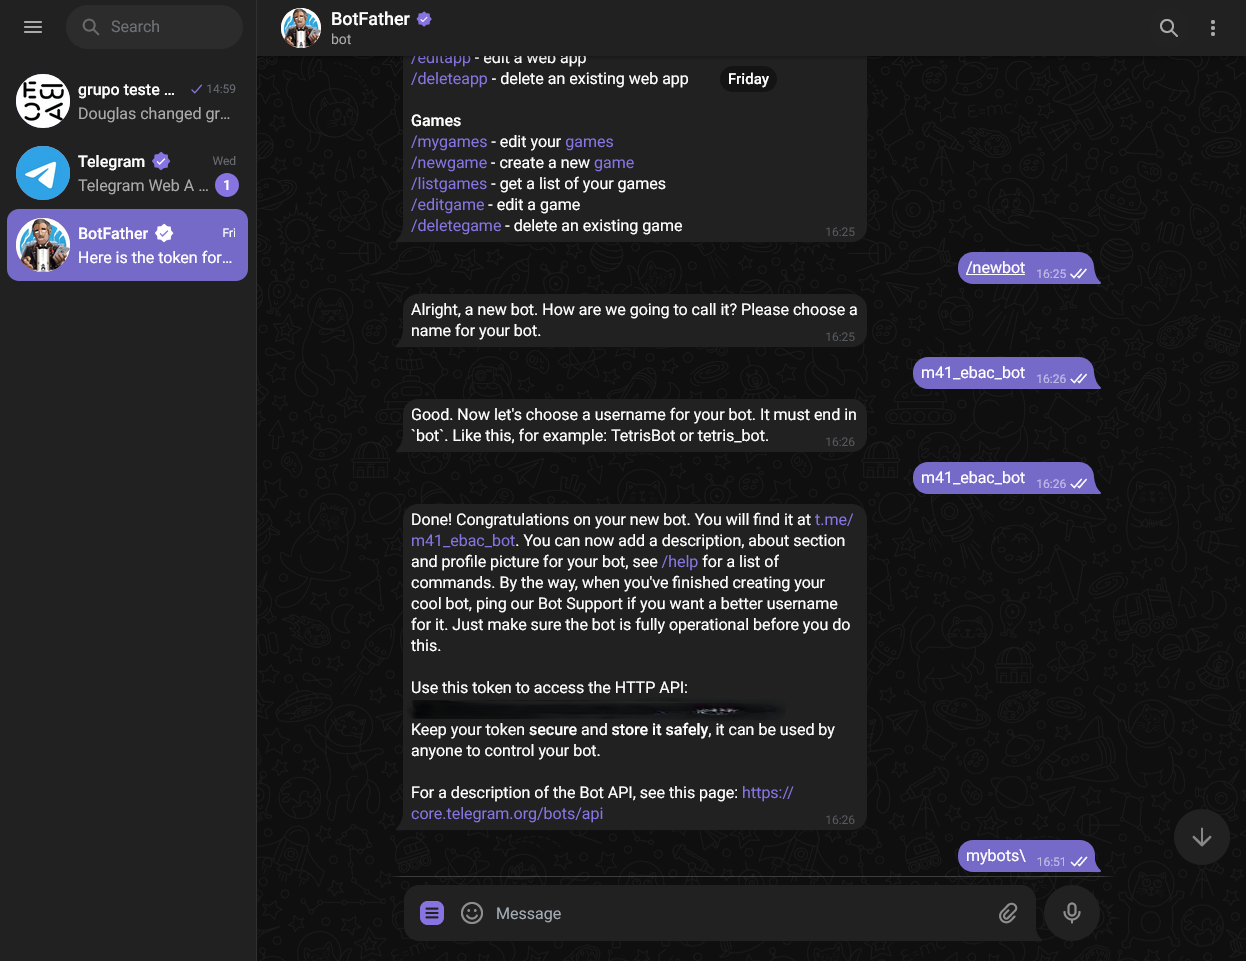

Para conferir o *token* novamente:

1. Abra o *chat* com o `BotFather`;
1. Digite `/mybots`;
1. Selecione o *bot* pelo seu nome de usuário;
1. Selecione `API Token`.

Por fim, precisamos ativiar o *bot*.

1. Abra o *chat* com o *bot*;
1. Selecione `start`.

### **2.3. Grupo**

Para criar um novo grupo.

1. Aperte o botão com o ícone de um lápis;
1. Selecione `New Group`;
1. Busque e selecione o *bot* recém criado pelo seu nome;
1. Aperte o botão com o ícone de uma seta;
1. Digite o nome do grupo.


Com o grupo criado, vamos adicionar o *bot* como administrador para que ele possa receber todas as mensagens do grupo. Uma outra opção seria desabilitar o seu modo de privacidade.

1. Abra o *chat* do grupo recém criado;
1. Abra o perfil do grupo;
1. Aperte o botão com o ícone de um lápis;
1. No campo de descrição do grupo escreva: **Atenção, todas as mensagens são armazenadas pelo *bot* do grupo**;
1. Selecione Administrators;
1. Aperte o botão com o ícone de um usuário;
1. Selecione o *bot*.
1. Aperte o botão com o ícone de um *check*.


Por fim, vamos configurar o *bot* para que ele não possa ser adicionado a outros grupos.

1. Abra o *chat* com o `BotFather`;
1. Digite `/mybots`;
1. Selecione o *bot* pelo seu nome de usuário;
1. Selecione `Bot Settings`;
1. Selecione `Allow Groups?`;
1. Selecione `Turn groups off`.

Com tudo pronto, envie algumas mensagens no grupo.

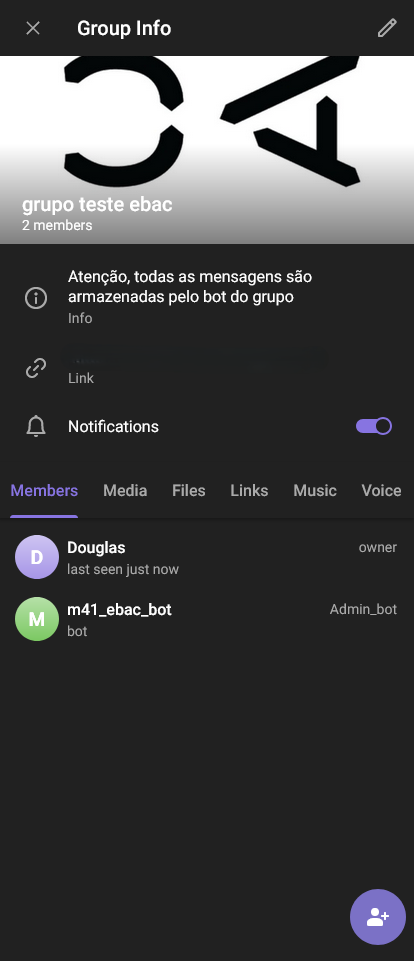

### **2.4. Bot API**

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

In [ ]:
from getpass import getpass

token = getpass()

··········


A `url` base é comum a todos os métodos da API.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**

O método `getMe` retorna informações sobre o *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')


 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 292380901,
      "message": {
        "message_id": 3,
        "from": {
          "id": 7266433120,
          "is_bot": false,
          "first_name": "Douglas"
        },
        "chat": {
          "id": -1002183205096,
          "title": "grupo teste ebac",
          "type": "supergroup"
        },
        "date": 1722628739,
        "text": "testando mensagem"
      }
    },
    {
      "update_id": 292380902,
      "message": {
        "message_id": 4,
        "from": {
          "id": 7266433120,
          "is_bot": false,
          "first_name": "Douglas"
        },
        "chat": {
          "id": -1002183205096,
          "title": "grupo teste ebac",
          "type": "supergroup"
        },
        "date": 1722692777,
        "text": "teste 2"
      }
    }
  ]
}


## 3\. Dados

Antes de avançar para etapa analítica, vamos trabalhar na manipulação dos dados de mensagens do **Telegram**.

### **3.1. Mensagem**

Uma mensagem recuperada via API é um dado semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais, estas últimas presentes (ou não) dependendo do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave `text` enquanto mensagens de áudio apresentam a chave `audio`. Neste projeto vamos focar em mensagens do tipo texto, ou seja, vamos ingerir as chaves mandatórias e a chave `text`.

> **Nota**: A lista completa das chaves disponíveis pode ser encontrada na documentação neste [link](https://core.telegram.org/bots/api#message).

 - Exemplo:

In [ ]:
%%writefile telegram.json
{
      "update_id": 292380901,
      "message": {
        "message_id": 3,
        "from": {
          "id": 7266433120,
          "is_bot": false,
          "first_name": "Douglas"
        },
        "chat": {
          "id": -1002183205096,
          "title": "grupo teste ebac",
          "type": "supergroup"
        },
        "date": 1722628739,
        "text": "testando mensagem"
      }
    }


Overwriting telegram.json


 - Descrição:

| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

### **3.2. Wrangling**

Vamos denormalizar o conteúdo da mensagem semi-estruturado no formato JSON utilizando apenas Python nativo, ou seja, sem o auxílio de pacotes, como Pandas.

Para começar, vamos carregar o arquivo `telegram.json` utilizando o pacote nativo `json`.

In [ ]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [ ]:
print(json.dumps(data, indent=2))

{
  "message_id": 3,
  "from": {
    "id": 7266433120,
    "is_bot": false,
    "first_name": "Douglas"
  },
  "chat": {
    "id": -1002183205096,
    "title": "grupo teste ebac",
    "type": "supergroup"
  },
  "date": 1722628739,
  "text": "testando mensagem"
}


Vamos então utilizar um laço de repetição para varrer todas as chaves do arquivo e selecionar apenas as de interesse. Caso a mensagem não possua a chave `text`, ela será criada com o valor igual a `None`. Além disso, vamos adicionar duas chaves de tempo para indicar o momento em que o dado foi processado: `context_date` e `context_timestamp`.

In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [3]
user_id: [7266433120]
user_is_bot: [False]
user_first_name: ['Douglas']
chat_id: [-1002183205096]
chat_type: ['supergroup']
date: [1722628739]
text: ['testando mensagem']
context_date: ['2024-08-09']
context_timestamp: ['2024-08-09 18:50:55']


Por fim, vamos utilizar o pacote Python PyArrow para criar uma tabela com os dados processado que, posteriormente, pode ser facilmente persistida em um arquivo no formato Apache Parquet.

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [ ]:
table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[3]]
user_id: [[7266433120]]
user_is_bot: [[false]]
user_first_name: [["Douglas"]]
chat_id: [[-1002183205096]]
chat_type: [["supergroup"]]
date: [[1722628739]]
text: [["testando mensagem"]]
context_date: [["2024-08-09"]]
context_timestamp: [["2024-08-09 18:50:55"]]